In [99]:
import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np

import brutesac
import utils

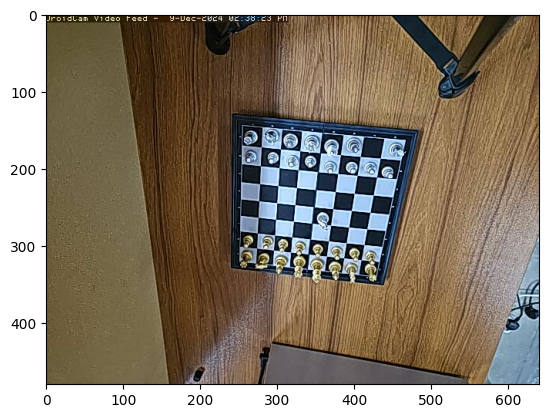

In [160]:
# src_image_path = "data/chessboard_3.jpeg"
# src_image = cv2.imread(src_image_path)

r, src_image = cv2.VideoCapture("http://192.168.0.100:4747/video").read()

# convert to RGB (otherwise when you display this image the colors will look incorrect)
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
# convert to grayscale before attempting corner detection
src_gray = cv2.cvtColor(src_image, cv2.COLOR_RGB2GRAY)

plt.imshow(src_image)
plt.show()

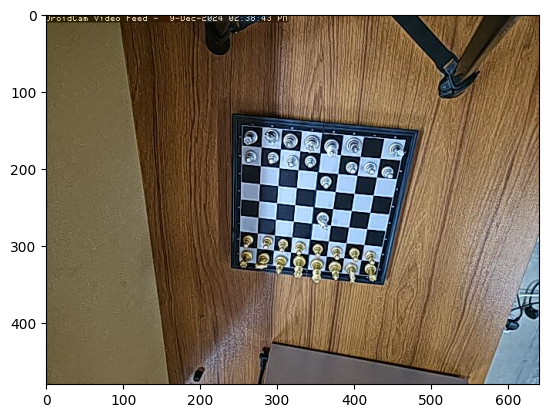

In [161]:
# src_image_path = "data/chessboard_3.jpeg"
# src_image = cv2.imread(src_image_path)

r, src_image2 = cv2.VideoCapture("http://192.168.0.100:4747/video").read()

# convert to RGB (otherwise when you display this image the colors will look incorrect)
src_image2 = cv2.cvtColor(src_image2, cv2.COLOR_BGR2RGB)
# convert to grayscale before attempting corner detection
src_gray2 = cv2.cvtColor(src_image2, cv2.COLOR_RGB2GRAY)

plt.imshow(src_image2)
plt.show()

In [152]:
def get_board_patches(src_image):
    src_gray = cv2.cvtColor(src_image, cv2.COLOR_RGB2GRAY)
    xpts = utils.classify_image(frame=src_gray)
    (
        raw_M,
        best_quad,
        best_offset,
        best_score,
        best_error_score,
    ) = brutesac.brutesac_chessboard(xpts)
    M_homog = brutesac.refine_homography(xpts, raw_M, best_offset)

    ideal_grid_pts = np.vstack(
        [np.array([0, 0, 1, 1, 0]) * 8 - 1, np.array([0, 1, 1, 0, 0]) * 8 - 1]
    ).T

    # Refined via homography of all valid points
    unwarped_ideal_chess_corners_homography = cv2.perspectiveTransform(
        np.expand_dims(ideal_grid_pts.astype(float), 0), np.linalg.inv(M_homog)
    )[0, :, :]

    a, b, c, d = unwarped_ideal_chess_corners_homography[:-1]
    candidates = [(a, b, c, d), (b, c, d, a), (c, d, a, b), (d, a, b, c)]

    for pt_A, pt_B, pt_C, pt_D in candidates:
        if np.all((pt_C - pt_A) > 0):
            if np.all((pt_D - pt_B) * (1, -1) < 0):
                pt_D, pt_B = pt_B, pt_D
            break

        # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32(
        [[0, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]]
    )

    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts, output_pts)

    out = cv2.warpPerspective(src_image, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    out = cv2.resize(out, (256, 256))

    patches = einops.rearrange(out, "(h h1) (w w1) c -> h w h1 w1 c", h=8, w=8)
    return patches


def get_grayscale_patches(patches):
    NH, NW, H, W, C = patches.shape
    patches_reshaped = patches.reshape(-1, H, W, C)
    grayscale_patches = np.array([cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY) for patch in patches_reshaped])
    grayscale_patches = grayscale_patches.reshape(NH, NH, H, W)
    return grayscale_patches


def erode_and_dilate_patches(patches):
    NH, NW, H, W = patches.shape
    patches_reshaped = patches.reshape(-1, H, W)
    eroded = np.array([cv2.erode(patch, np.ones((5, 5), np.uint8)) for patch in patches_reshaped])
    dilated = np.array([cv2.dilate(patch, np.ones((5, 5), np.uint8)) for patch in eroded])
    dilated = dilated.reshape(NH, NW, H, W)
    return dilated

In [37]:
xpts = utils.classify_image(frame=src_gray)
(
    raw_M,
    best_quad,
    best_offset,
    best_score,
    best_error_score,
) = brutesac.brutesac_chessboard(xpts)
M_homog = brutesac.refine_homography(xpts, raw_M, best_offset)

pts_warped2 = cv2.perspectiveTransform(np.expand_dims(xpts.astype(float), 0), M_homog)[
    0, :, :
]

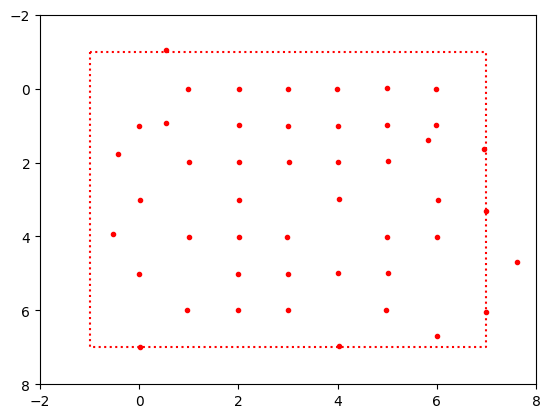

In [38]:
ideal_grid_pts = np.vstack(
    [np.array([0, 0, 1, 1, 0]) * 8 - 1, np.array([0, 1, 1, 0, 0]) * 8 - 1]
).T

plt.plot(ideal_grid_pts[:, 0], ideal_grid_pts[:, 1], "r:")
plt.plot(pts_warped2[:, 0], pts_warped2[:, 1], "r.")
plt.xlim(-2, 8)
plt.ylim(8, -2)
plt.show()

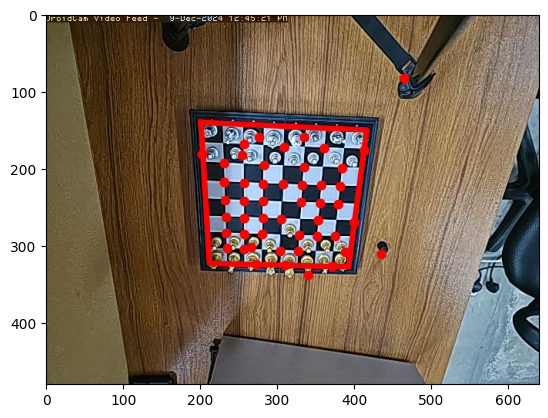

In [39]:
plt.imshow(src_image)
plt.plot(xpts[:, 0], xpts[:, 1], "ro")

# Refined via homography of all valid points
unwarped_ideal_chess_corners_homography = cv2.perspectiveTransform(
    np.expand_dims(ideal_grid_pts.astype(float), 0), np.linalg.inv(M_homog)
)[0, :, :]

plt.plot(
    unwarped_ideal_chess_corners_homography[:, 0],
    unwarped_ideal_chess_corners_homography[:, 1],
    "r-",
    lw=4,
)
plt.show()

In [40]:
a, b, c, d = unwarped_ideal_chess_corners_homography[:-1]
candidates = [(a, b, c, d), (b, c, d, a), (c, d, a, b), (d, a, b, c)]

for pt_A, pt_B, pt_C, pt_D in candidates:
    if np.all((pt_C - pt_A) > 0):
        if np.all((pt_D - pt_B) * (1, -1) < 0):
            pt_D, pt_B = pt_B, pt_D
        break

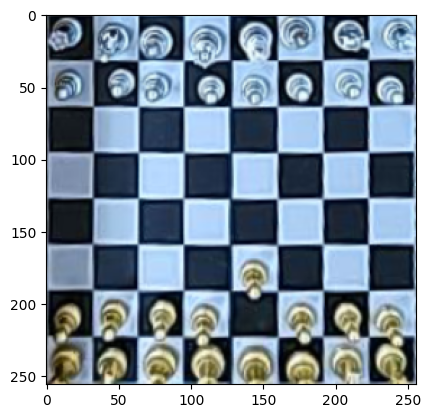

In [41]:
# Here, I have used L2 norm. You can use L1 also.
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32(
    [[0, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]]
)

# Compute the perspective transform M
M = cv2.getPerspectiveTransform(input_pts, output_pts)

out = cv2.warpPerspective(src_image, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
out = cv2.resize(out, (256, 256))

plt.imshow(out)
plt.show()

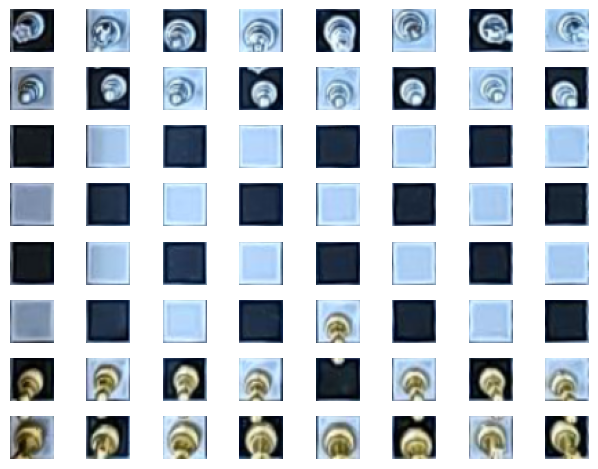

In [42]:
patches = einops.rearrange(out, "(h h1) (w w1) c -> h w h1 w1 c", h=8, w=8)

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8 * i + j + 1)
        plt.imshow(patches[i, j])
        plt.axis("off")

plt.tight_layout()
plt.show()

### Scratch

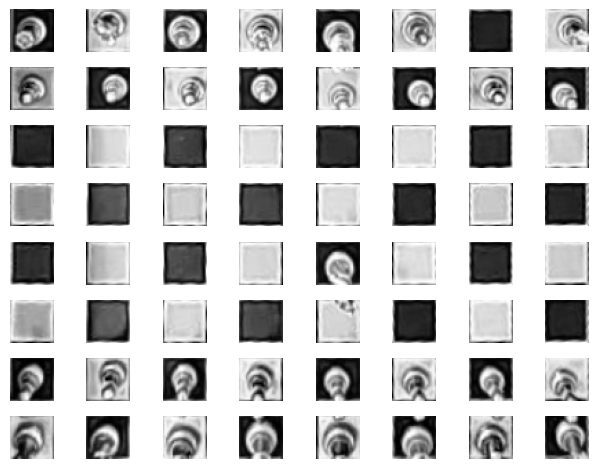

In [162]:
patches = get_grayscale_patches(get_board_patches(src_image))

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8 * i + j + 1)
        plt.imshow(patches[i, j], cmap="gray")
        plt.axis("off")

plt.tight_layout()
plt.show()

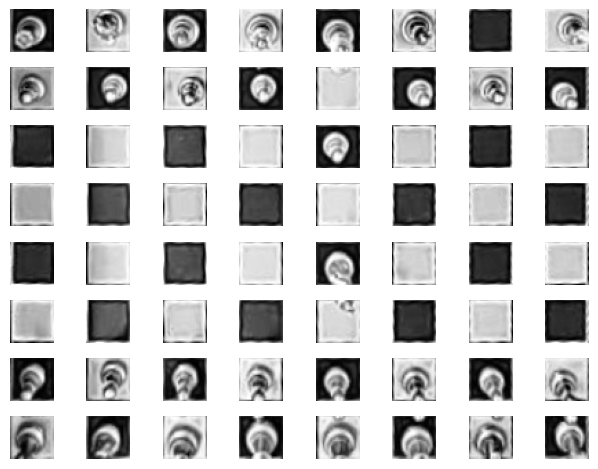

In [163]:
patches2 = get_grayscale_patches(get_board_patches(src_image2))

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8 * i + j + 1)
        plt.imshow(patches2[i, j], cmap="gray")
        plt.axis("off")

plt.tight_layout()
plt.show()

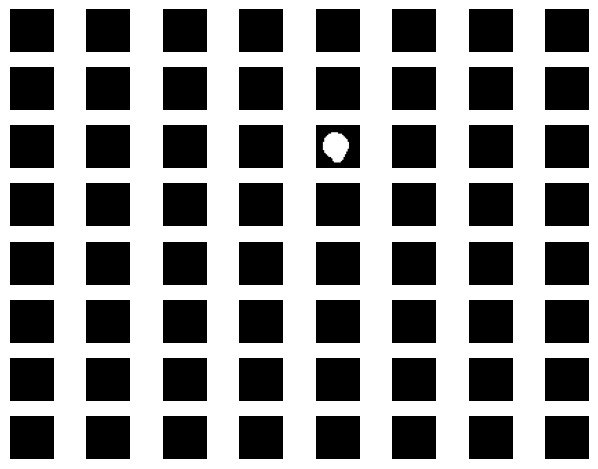

In [167]:
diff = np.abs(patches - patches2)
diff = np.where((diff < 50) | (diff > 200), 0, 255).astype(np.uint8)
diff = erode_and_dilate_patches(diff)

for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8 * i + j + 1)
        plt.imshow(diff[i, j], cmap="gray", vmin=0, vmax=255)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [156]:
map1 = ["A", "B", "C", "D", "E", "F", "G", "H"]
map2 = ["1", "2", "3", "4", "5", "6", "7", "8"]

In [158]:
indices = np.argwhere(diff.mean(axis=(-1, -2)).round(2) > 50)
a, b = indices

map1[a[0]] + map2[a[1]], map1[b[0]] + map2[b[1]]

('A7', 'E5')

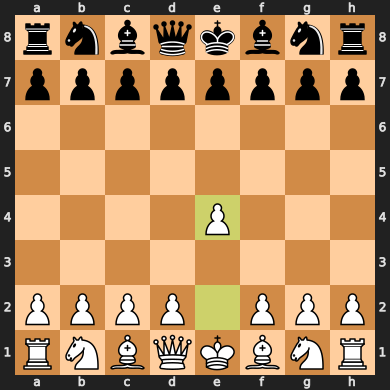

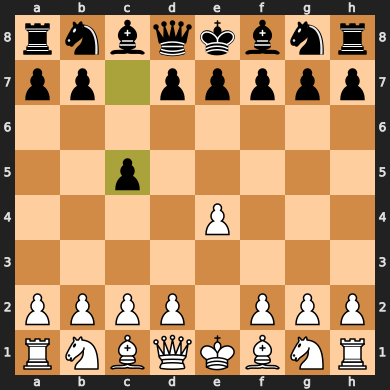

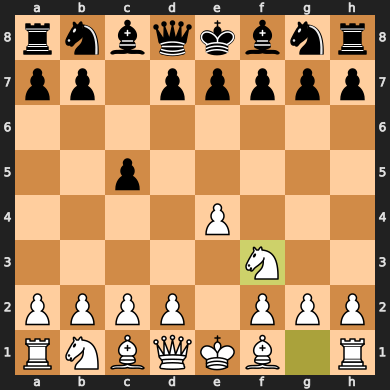

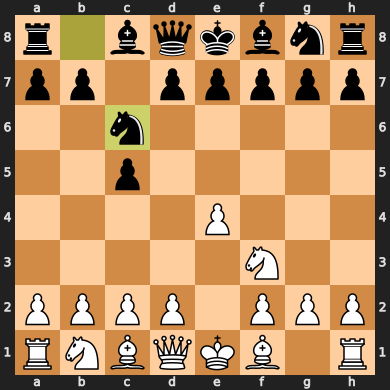

In [9]:
import chess
import chess.engine

board = chess.Board()

engine = chess.engine.SimpleEngine.popen_uci(
    "/home/umong/bin/stockfish/stockfish-ubuntu-x86-64-avx2"
)

board.push_san("e2e4")
display(board)

result = engine.play(board, chess.engine.Limit(time=0.1))
board.push(result.move)
display(board)

board.push_san("g1f3")
display(board)

result = engine.play(board, chess.engine.Limit(time=0.1))
board.push(result.move)
display(board)